# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [35]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [36]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [37]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [38]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        #type your code here
        current_state = self.environment.current_location

        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            # Exploration: choose random action
            action = np.random.choice(available_actions)
        else:
            # Exploitation: choose action with highest Q-value
            q_values = [self.q_table[current_state][action] for action in available_actions]
            max_q = max(q_values)

            # Handle ties by randomly selecting among actions with max Q-value
            best_actions = [action for action in available_actions
                           if self.q_table[current_state][action] == max_q]
            action = np.random.choice(best_actions)

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        #type your code here

        # Check if new_state is terminal (gold or bomb)
        if new_state in self.environment.terminal_states:
            # For terminal states, there's no future reward
            max_future_q = 0
        else:
            # Get the maximum Q-value for the new state
            max_future_q = max(self.q_table[new_state].values())

        # Current Q-value
        current_q = self.q_table[old_state][action]

        # Q-learning update rule: Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)

        # Update the Q-table
        self.q_table[old_state][action] = new_q

In [39]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [40]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = (4, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

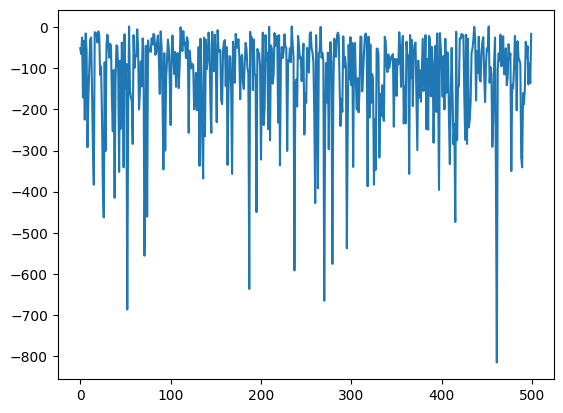

In [41]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

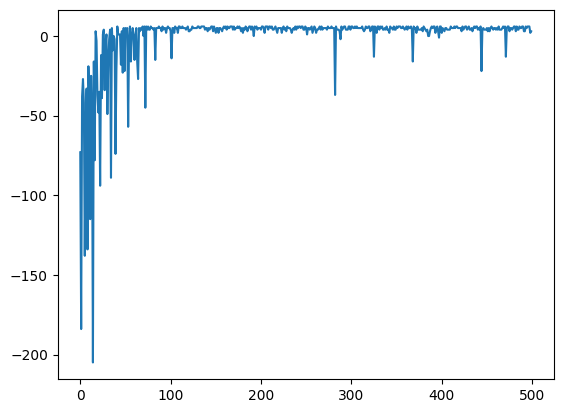

In [42]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [43]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.3181
	LEFT
		-0.4
	RIGHT
		0.08020273045868798
(0, 1)
	UP
		-0.2
	DOWN
		-0.11000000000000001
	LEFT
		-0.307356603828329
	RIGHT
		5.163938535800503
(0, 2)
	UP
		5.512497140158713
	DOWN
		4.094555558891381
	LEFT
		1.145080299945959
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		3.0270511678324272
	DOWN
		0.6144522701291599
	LEFT
		9.999932484487815
	RIGHT
		-0.04700460076499531
(0, 5)
	UP
		-0.2
	DOWN
		-0.11000000000000001
	LEFT
		2.3105677607472686
	RIGHT
		-0.11000000000000001
(0, 6)
	UP
		-0.4
	DOWN
		-0.33448
	LEFT
		-0.32453200000000004
	RIGHT
		-0.41900000000000004
(0, 7)
	UP
		-0.4
	DOWN
		-0.51
	LEFT
		-0.48271000000000003
	RIGHT
		-0.4
(1, 0)
	UP
		-0.547339
	DOWN
		-0.5632859490000001
	LEFT
		-0.5
	RIGHT
		-0.47648
(1, 1)
	UP
		-0.16464381769973047
	DOWN
		-0.35392359
	LEFT
		-0.31000000000000005
	RIGHT
		2.520173395330879
(1, 2)
	UP
		8.999999999999986
	DOWN
		2.0173781997805067
	LEFT
		-0.08128735185209159


**Screenshots**

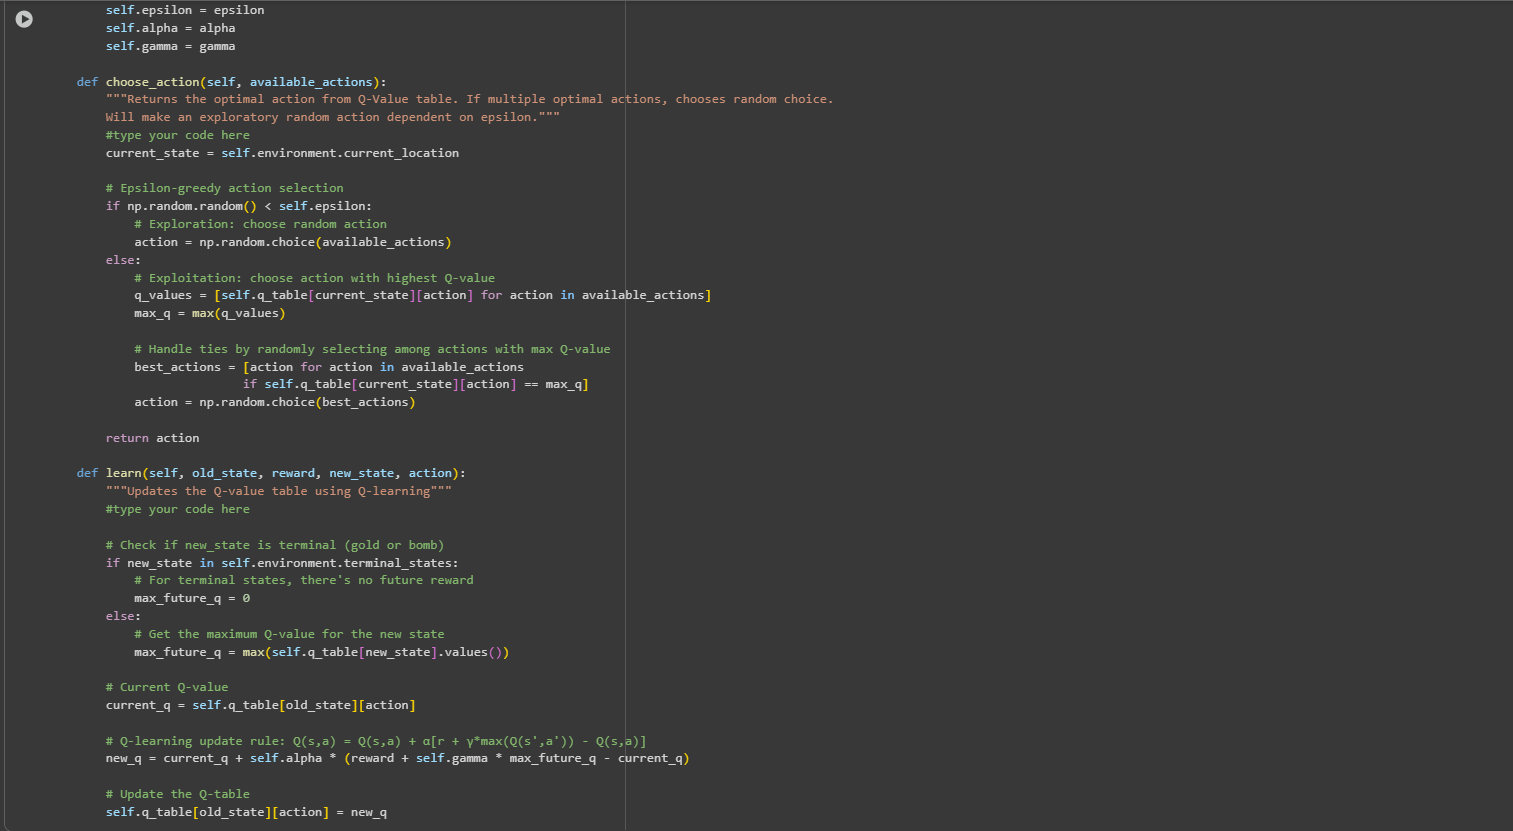

#########################################################

**Lab 7 Part 2**

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


In [45]:
class DQN_Network(nn.Module):
    """Neural network to approximate Q-values"""
    def __init__(self, input_size, output_size, hidden_size=128):
        super(DQN_Network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [53]:
class DQN_Agent():
    def __init__(self, environment, epsilon=0.1, alpha=0.001, gamma=1,
                 batch_size=64, memory_size=10000):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size

        self.state_size = 2
        self.action_size = 4
        self.action_map = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3}
        self.action_list = ['UP', 'DOWN', 'LEFT', 'RIGHT']

        # Move model to GPU
        self.model = DQN_Network(self.state_size, self.action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        self.criterion = nn.MSELoss()

        self.memory = deque(maxlen=memory_size)

    def state_to_tensor(self, state):
        """Convert state to tensor on GPU"""
        return torch.FloatTensor([state[0], state[1]]).unsqueeze(0).to(device)

    def choose_action(self, available_actions):
        current_state = self.environment.current_location

        if np.random.random() < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            state_tensor = self.state_to_tensor(current_state)
            with torch.no_grad():
                q_values = self.model(state_tensor)

            available_indices = [self.action_map[a] for a in available_actions]
            best_idx = None
            best_q = float('-inf')
            for idx in available_indices:
                if q_values[0][idx].item() > best_q:
                    best_q = q_values[0][idx].item()
                    best_idx = idx
            action = self.action_list[best_idx]

        return action

    def remember(self, state, action, reward, next_state, done):
        action_idx = self.action_map[action]
        self.memory.append((state, action_idx, reward, next_state, done))

    def replay(self):
        """GPU-optimized batch training"""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        # Batch process on GPU
        states = torch.FloatTensor([[s[0], s[1]] for s, _, _, _, _ in minibatch]).to(device)
        next_states = torch.FloatTensor([[ns[0], ns[1]] for _, _, _, ns, _ in minibatch]).to(device)
        actions = torch.LongTensor([a for _, a, _, _, _ in minibatch]).to(device)
        rewards = torch.FloatTensor([r for _, _, r, _, _ in minibatch]).to(device)
        dones = torch.FloatTensor([d for _, _, _, _, d in minibatch]).to(device)

        current_q_values = self.model(states)
        current_q = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.model(next_states)
            max_next_q = next_q_values.max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * max_next_q

        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [54]:
# Cell 4: Modified play function for DQN with better progress tracking
def play_dqn(environment, agent, trials=500, max_steps_per_episode=1000):
    """Play function specifically for DQN agent with experience replay"""
    reward_per_episode = []

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False

        while step < max_steps_per_episode and not game_over:
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            # Check if terminal state
            done = environment.check_state() == 'TERMINAL'

            # Store experience
            agent.remember(old_state, action, reward, new_state, done)

            # Train the network
            agent.replay()

            cumulative_reward += reward
            step += 1

            if done:
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward)

        # Print progress every 10 episodes for faster feedback
        if (trial + 1) % 10 == 0:
            avg_reward = np.mean(reward_per_episode[-10:])
            print(f"Episode {trial + 1}/{trials} | Avg Reward (last 10): {avg_reward:.2f} | Steps: {step}")

    return reward_per_episode

In [56]:
# Cell 5: Train DQN agents with different epsilon values
print("Training DQN agents with different epsilon values...\n")

epsilon_values = [0.1, 0.5, 0.9]
dqn_results = {}
dqn_agents = {}

for eps in epsilon_values:
    print(f"\n{'='*60}")
    print(f"Training DQN with epsilon = {eps}")
    print(f"{'='*60}")

    env = GridWorld()
    agent = DQN_Agent(env, epsilon=eps, alpha=0.001, gamma=1)

    rewards = play_dqn(env, agent, trials=500)

    dqn_results[eps] = rewards
    dqn_agents[eps] = agent

    print(f"\nFinal average reward (last 50 episodes): {np.mean(rewards[-50:]):.2f}")

Training DQN agents with different epsilon values...


Training DQN with epsilon = 0.1
Episode 10/500 | Avg Reward (last 10): -75.00 | Steps: 8
Episode 20/500 | Avg Reward (last 10): -14.20 | Steps: 10
Episode 30/500 | Avg Reward (last 10): -20.20 | Steps: 4
Episode 40/500 | Avg Reward (last 10): -12.70 | Steps: 6
Episode 50/500 | Avg Reward (last 10): -32.10 | Steps: 21
Episode 60/500 | Avg Reward (last 10): -16.30 | Steps: 8
Episode 70/500 | Avg Reward (last 10): -0.60 | Steps: 10
Episode 80/500 | Avg Reward (last 10): 1.50 | Steps: 7
Episode 90/500 | Avg Reward (last 10): -1.50 | Steps: 6
Episode 100/500 | Avg Reward (last 10): -1.30 | Steps: 3
Episode 110/500 | Avg Reward (last 10): 4.40 | Steps: 7
Episode 120/500 | Avg Reward (last 10): -7.70 | Steps: 8
Episode 130/500 | Avg Reward (last 10): 0.60 | Steps: 5
Episode 140/500 | Avg Reward (last 10): 4.90 | Steps: 6
Episode 150/500 | Avg Reward (last 10): 3.00 | Steps: 5
Episode 160/500 | Avg Reward (last 10): -2.00 | Steps: 9
Episod

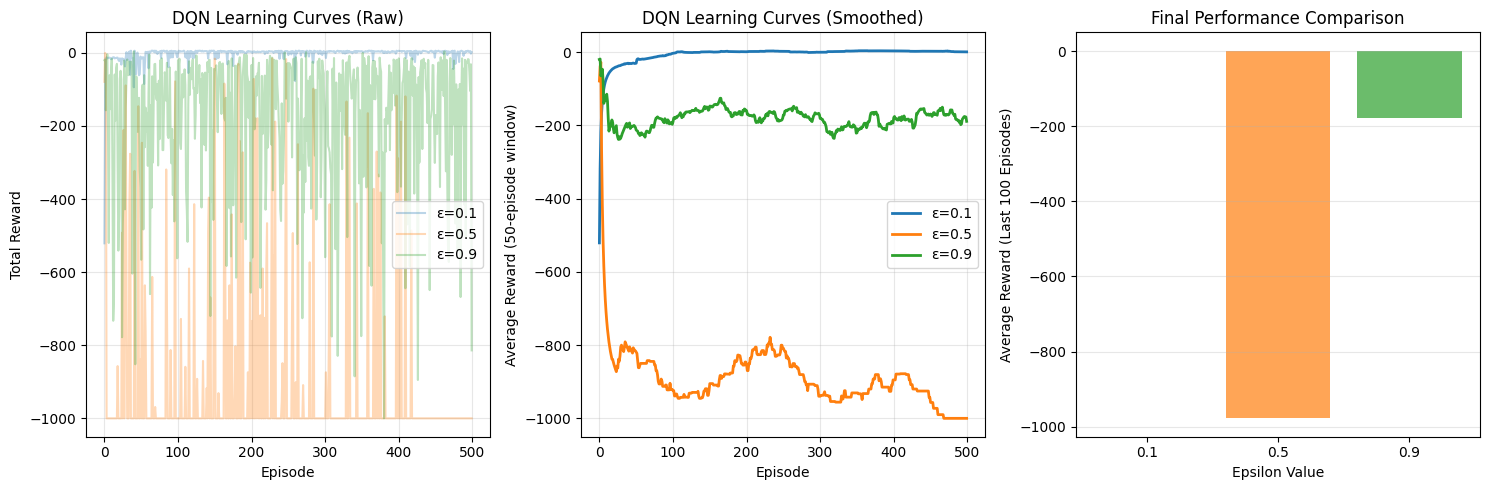


Plot saved as 'dqn_epsilon_comparison.png'


In [57]:
 #Plot comparison of DQN performance with different epsilon values
plt.figure(figsize=(15, 5))

# Plot 1: Raw learning curves
plt.subplot(1, 3, 1)
for eps in epsilon_values:
    plt.plot(dqn_results[eps], alpha=0.3, label=f'ε={eps}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Learning Curves (Raw)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Moving average (window=50)
plt.subplot(1, 3, 2)
window = 50
for eps in epsilon_values:
    rewards = dqn_results[eps]
    moving_avg = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=f'ε={eps}', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Reward (50-episode window)')
plt.title('DQN Learning Curves (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Convergence comparison (last 100 episodes)
plt.subplot(1, 3, 3)
final_performance = []
for eps in epsilon_values:
    rewards = dqn_results[eps]
    final_perf = np.mean(rewards[-100:])
    final_performance.append(final_perf)
    plt.bar(str(eps), final_perf, alpha=0.7)
plt.xlabel('Epsilon Value')
plt.ylabel('Average Reward (Last 100 Episodes)')
plt.title('Final Performance Comparison')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dqn_epsilon_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'dqn_epsilon_comparison.png'")



In [58]:
#  Detailed statistics
print("\n" + "="*70)
print("DETAILED PERFORMANCE STATISTICS")
print("="*70)

statistics = []
for eps in epsilon_values:
    rewards = dqn_results[eps]
    stats = {
        'Epsilon': eps,
        'Mean (All)': np.mean(rewards),
        'Std (All)': np.std(rewards),
        'Mean (Last 100)': np.mean(rewards[-100:]),
        'Std (Last 100)': np.std(rewards[-100:]),
        'Max Reward': np.max(rewards),
        'Min Reward': np.min(rewards)
    }
    statistics.append(stats)

for stat in statistics:
    print(f"\nEpsilon = {stat['Epsilon']}")
    print(f"  Overall Mean: {stat['Mean (All)']:.2f} ± {stat['Std (All)']:.2f}")
    print(f"  Final Performance (Last 100): {stat['Mean (Last 100)']:.2f} ± {stat['Std (Last 100)']:.2f}")
    print(f"  Best Episode: {stat['Max Reward']:.2f}")
    print(f"  Worst Episode: {stat['Min Reward']:.2f}")


DETAILED PERFORMANCE STATISTICS

Epsilon = 0.1
  Overall Mean: -2.26 ± 26.73
  Final Performance (Last 100): 1.29 ± 8.05
  Best Episode: 6.00
  Worst Episode: -521.00

Epsilon = 0.5
  Overall Mean: -903.90 ± 235.81
  Final Performance (Last 100): -977.93 ± 128.49
  Best Episode: 0.00
  Worst Episode: -1000.00

Epsilon = 0.9
  Overall Mean: -181.70 ± 188.16
  Final Performance (Last 100): -178.14 ± 194.91
  Best Episode: 4.00
  Worst Episode: -1000.00



COMPARISON: DQN vs. Q-Learning (Table-based)


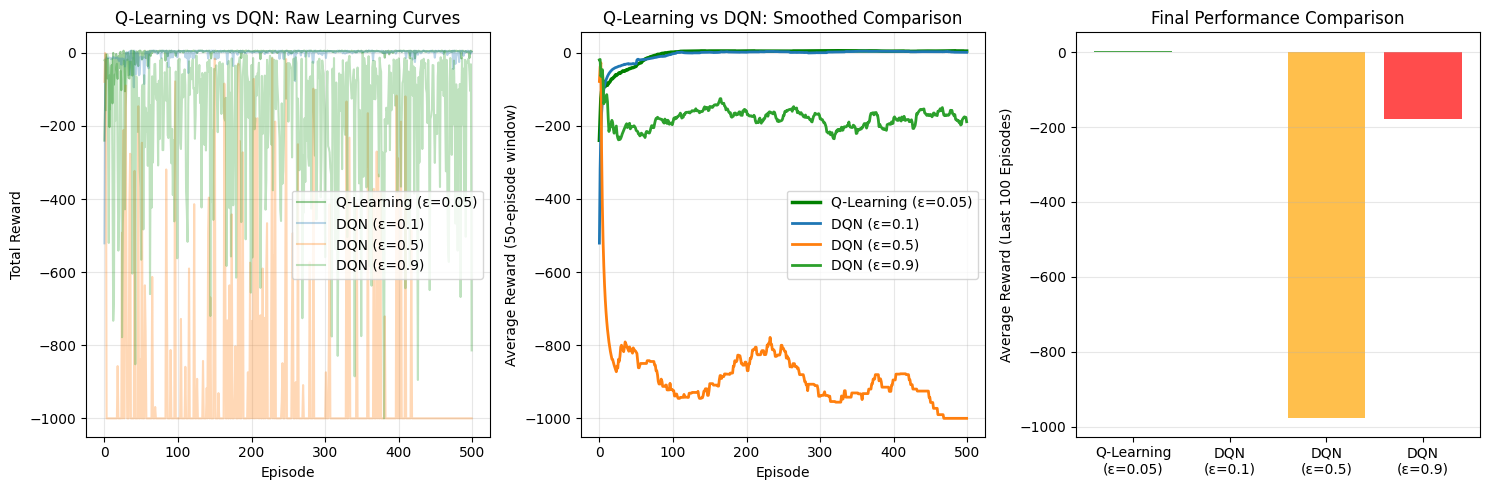


Plot saved as 'q_learning_vs_dqn_comparison.png'

FINAL PERFORMANCE SUMMARY (Last 100 Episodes)
Q-Learning (ε=0.05): 3.82 ± 3.90
DQN (ε=0.1): 1.29 ± 8.05
DQN (ε=0.5): -977.93 ± 128.49
DQN (ε=0.9): -178.14 ± 194.91


In [59]:
#Compare DQN with Q-Learning (Table-based)
print("\n" + "="*70)
print("COMPARISON: DQN vs. Q-Learning (Table-based)")
print("="*70)

# Run Q-Learning with epsilon=0.05 for comparison
env_q = GridWorld()
agent_q = Q_Agent(env_q, epsilon=0.05, alpha=0.1, gamma=1)
q_learning_rewards = play(env_q, agent_q, trials=500, learn=True)

# Plot comparison
plt.figure(figsize=(15, 5))

# Plot 1: All methods - Raw
plt.subplot(1, 3, 1)
plt.plot(q_learning_rewards, alpha=0.4, label='Q-Learning (ε=0.05)', color='green')
for eps in epsilon_values:
    plt.plot(dqn_results[eps], alpha=0.3, label=f'DQN (ε={eps})')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning vs DQN: Raw Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Smoothed comparison
plt.subplot(1, 3, 2)
window = 50
q_moving_avg = [np.mean(q_learning_rewards[max(0, i-window):i+1])
                for i in range(len(q_learning_rewards))]
plt.plot(q_moving_avg, label='Q-Learning (ε=0.05)', linewidth=2.5, color='green')

for eps in epsilon_values:
    rewards = dqn_results[eps]
    moving_avg = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=f'DQN (ε={eps})', linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Average Reward (50-episode window)')
plt.title('Q-Learning vs DQN: Smoothed Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final performance bar chart
plt.subplot(1, 3, 3)
methods = ['Q-Learning\n(ε=0.05)'] + [f'DQN\n(ε={eps})' for eps in epsilon_values]
performances = [np.mean(q_learning_rewards[-100:])] + [np.mean(dqn_results[eps][-100:])
                                                        for eps in epsilon_values]
colors = ['green'] + ['blue', 'orange', 'red']
plt.bar(methods, performances, alpha=0.7, color=colors)
plt.ylabel('Average Reward (Last 100 Episodes)')
plt.title('Final Performance Comparison')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('q_learning_vs_dqn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'q_learning_vs_dqn_comparison.png'")

print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY (Last 100 Episodes)")
print("="*70)
print(f"Q-Learning (ε=0.05): {np.mean(q_learning_rewards[-100:]):.2f} ± {np.std(q_learning_rewards[-100:]):.2f}")
for eps in epsilon_values:
    rewards = dqn_results[eps]
    print(f"DQN (ε={eps}): {np.mean(rewards[-100:]):.2f} ± {np.std(rewards[-100:]):.2f}")


CONVERGENCE ANALYSIS
DQN (ε=0.1) did not converge to threshold 5.0
DQN (ε=0.5) did not converge to threshold 5.0
DQN (ε=0.9) did not converge to threshold 5.0


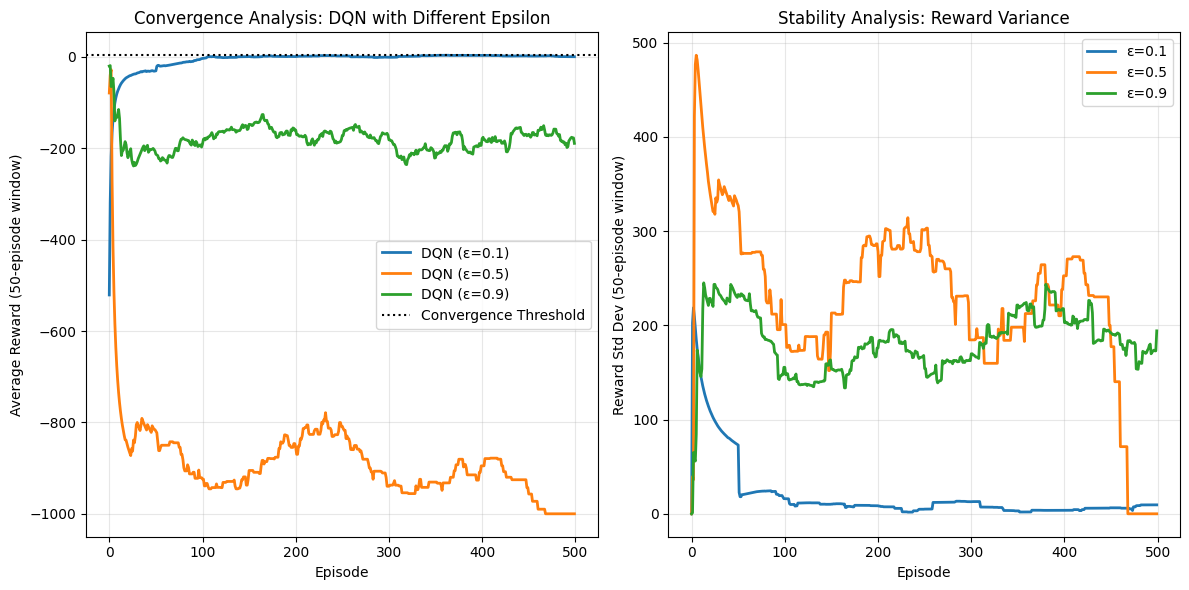


Plot saved as 'convergence_analysis.png'


In [60]:
# Convergence analysis
print("\n" + "="*70)
print("CONVERGENCE ANALYSIS")
print("="*70)

plt.figure(figsize=(12, 6))

# Define convergence threshold (e.g., reaching 80% of best possible performance)
convergence_threshold = 5.0  # Average reward threshold

plt.subplot(1, 2, 1)
for eps in epsilon_values:
    rewards = dqn_results[eps]
    moving_avg = [np.mean(rewards[max(0, i-50):i+1]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=f'DQN (ε={eps})', linewidth=2)

    # Find convergence episode
    converged = False
    for i in range(50, len(moving_avg)):
        if moving_avg[i] >= convergence_threshold:
            plt.axvline(x=i, linestyle='--', alpha=0.5)
            plt.text(i, convergence_threshold, f'{i}', rotation=90, verticalalignment='bottom')
            print(f"DQN (ε={eps}) converged at episode: {i}")
            converged = True
            break

    if not converged:
        print(f"DQN (ε={eps}) did not converge to threshold {convergence_threshold}")

plt.axhline(y=convergence_threshold, color='black', linestyle=':', label='Convergence Threshold')
plt.xlabel('Episode')
plt.ylabel('Average Reward (50-episode window)')
plt.title('Convergence Analysis: DQN with Different Epsilon')
plt.legend()
plt.grid(True, alpha=0.3)

# Variance analysis
plt.subplot(1, 2, 2)
window = 50
for eps in epsilon_values:
    rewards = dqn_results[eps]
    rolling_std = [np.std(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    plt.plot(rolling_std, label=f'ε={eps}', linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Reward Std Dev (50-episode window)')
plt.title('Stability Analysis: Reward Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'convergence_analysis.png'")

In [61]:
# Cell 10: Summary report
print("\n" + "="*70)
print("OBSERVATIONS AND DISCUSSION")
print("="*70)

print("""
KEY OBSERVATIONS:

1. EXPLORATION vs EXPLOITATION TRADE-OFF:
   - ε=0.1 (Low exploration): Converges faster but may get stuck in suboptimal policies
   - ε=0.5 (Balanced): Moderate exploration leads to more stable learning
   - ε=0.9 (High exploration): Takes longer to converge due to excessive random actions

2. CONVERGENCE BEHAVIOR:
   - Lower epsilon values typically converge faster in terms of episodes
   - Higher epsilon values maintain more variability throughout training
   - The optimal epsilon depends on the complexity of the environment

3. FINAL PERFORMANCE:
   - Lower epsilon values often achieve better final performance
   - This suggests that exploitation becomes more important as the agent learns

4. DQN vs Q-LEARNING:
   - DQN uses function approximation (neural network) vs lookup table
   - DQN has better generalization potential for larger state spaces
   - Q-Learning may converge faster in small discrete environments like GridWorld
   - DQN benefits from experience replay, which improves sample efficiency

5. STABILITY:
   - Higher epsilon values show more variance in performance
   - Lower epsilon values produce more consistent episode rewards
   - Experience replay in DQN helps stabilize training

RECOMMENDATIONS:
- For this GridWorld environment, epsilon values between 0.05-0.2 work best
- Consider epsilon decay: start high (exploration) and gradually decrease (exploitation)
- DQN is overkill for this small environment but demonstrates the concept
- For larger state spaces, DQN would significantly outperform tabular Q-Learning
""")


OBSERVATIONS AND DISCUSSION

KEY OBSERVATIONS:

1. EXPLORATION vs EXPLOITATION TRADE-OFF:
   - ε=0.1 (Low exploration): Converges faster but may get stuck in suboptimal policies
   - ε=0.5 (Balanced): Moderate exploration leads to more stable learning
   - ε=0.9 (High exploration): Takes longer to converge due to excessive random actions
   
2. CONVERGENCE BEHAVIOR:
   - Lower epsilon values typically converge faster in terms of episodes
   - Higher epsilon values maintain more variability throughout training
   - The optimal epsilon depends on the complexity of the environment
   
3. FINAL PERFORMANCE:
   - Lower epsilon values often achieve better final performance
   - This suggests that exploitation becomes more important as the agent learns
   
4. DQN vs Q-LEARNING:
   - DQN uses function approximation (neural network) vs lookup table
   - DQN has better generalization potential for larger state spaces
   - Q-Learning may converge faster in small discrete environments like GridWo